In [59]:
import requests
from bs4 import BeautifulSoup

import pandas as pd
import numpy as np
from sklearn.linear_model import LinearRegression

from bs4 import BeautifulSoup

from selenium import webdriver
from selenium.webdriver.chrome.service import Service
from webdriver_manager.chrome import ChromeDriverManager
from selenium.webdriver.common.by import By
from selenium.webdriver.chrome.options import Options

from multiprocessing.pool import ThreadPool, Pool
import threading
from tqdm import tqdm
import csv

import os

from matplotlib import pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

import datetime

# pd.set_option('display.max_rows', None)
# pd.set_option('display.max_columns', None)
# pd.set_option('display.width', None)

In [60]:
season = 8
root_folder = './challenger_datas/'

In [61]:
for (dirpath, dirnames, filenames) in os.walk(root_folder):
    print(filenames)

['S7-2023-01-10.csv', 'S8-2023-01-17.csv']


In [62]:
#file_name = 'S%d-%s.csv' % (season, datetime.date.today())
file_name = 'S7-2023-01-10.csv'

file_path = os.path.join(root_folder, file_name)

In [63]:
if not os.path.exists(file_path):
    threadLocal = threading.local()

    response = requests.get(
    "https://sea.wildstats.gg/en/leaderboard")
    soup = BeautifulSoup(response.text, "html.parser")
    elements = soup.findAll('a', attrs = {'class' : 'text-truncate'})
    leaderboard = [
        (
            'https://sea.wildstats.gg'+element.attrs["href"], 
            element.findChildren("span")[0].text
        ) for element in elements
    ]

    print('total datas number:', len(leaderboard))
    print('top 5 players:')
    print(leaderboard[:5])

    def get_driver():
        driver = getattr(threadLocal, 'driver', None)
        if driver is None:
            chrome_options = Options()
            chrome_options.add_argument("--headless")
            driver = webdriver.Chrome(service=Service(ChromeDriverManager().install()), 
                                        options=chrome_options)

            setattr(threadLocal, 'driver', driver)
        return driver

    def scrap(data):
        url, id = data

        driver = get_driver()

        driver.get(url)
        html = driver.page_source
        soup = BeautifulSoup(html, features="html.parser")
        row_datas = soup.findAll('h1', attrs={'class': 'text-center m-0'})

        row_datas_text = [data.text for data in row_datas]
        marks = soup.find('span', attrs={'class':'badge badge-overlay text-white'}).findAll('div')[1].text.strip()
        return (marks, *row_datas_text, url)

    with ThreadPool(5) as p:
        challenger_datas = list(tqdm(p.imap(scrap, leaderboard), total=len(leaderboard)))
    driver = get_driver()
    driver.quit()

    df = pd.DataFrame(challenger_datas, columns=['Marks', 'WinRate', 'MVP', 'Played', 'URL'])

    df.to_csv(file_path, index=False)
else:
    df = pd.read_csv(file_path)

In [64]:
print(df.head())

   Marks WinRate  MVP  Played  \
0      1  81.82%    8      22   
1      1  94.12%    0      17   
2      6  88.89%    9      27   
3      5  88.24%    2      17   
4      4  78.95%    2      19   

                                                 URL  
0  https://sea.wildstats.gg/en/profile/J9b5FYRbpb...  
1  https://sea.wildstats.gg/en/profile/ieTFSECMjK...  
2  https://sea.wildstats.gg/en/profile/D7Bg0sbnIi...  
3  https://sea.wildstats.gg/en/profile/BE6p43HIWJ...  
4  https://sea.wildstats.gg/en/profile/7q6prsD5Ag...  


In [65]:
df['Marks'] = df['Marks'].astype('int')
df['WinRate'] = df['WinRate'].str.rstrip('%').astype('float')
df['MVP'] = df['MVP'].astype('int') 
df['Played'] = df['Played'].astype('str').str.replace(',', '').astype('int')

```
df['Marks']
df['WinRate']
df['MVP'] / df['Played']
```

0.070747007922629


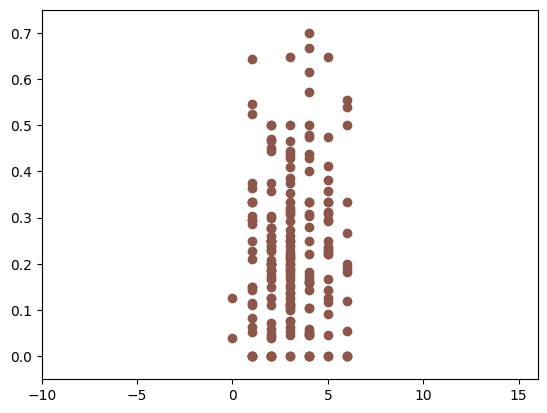

In [66]:
x = df['Marks']
y = df['MVP'] / df['Played']

print(np.corrcoef(x, y)[0, 1])

fig, ax = plt.subplots()

ax.set_xlim((x.min()-10, x.max()+10))
ax.set_ylim((y.min()-0.05, y.max()+0.05))

ax.plot(x, y, 'o', color='tab:brown')

plt.show()

0.13990054983597616


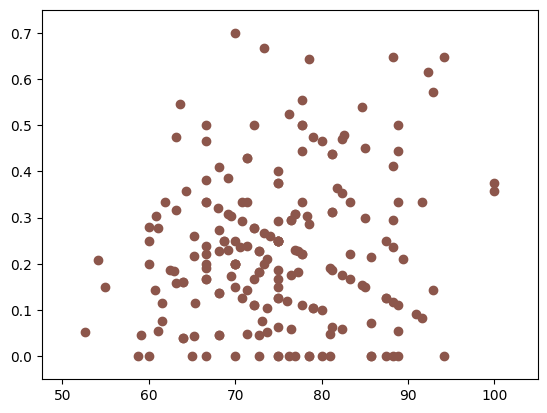

In [67]:
x = df['WinRate']
y = df['MVP'] / df['Played']

print(np.corrcoef(x, y)[0, 1])

fig, ax = plt.subplots()

ax.set_xlim((x.min()-5, x.max()+5))
ax.set_ylim((y.min()-0.05, y.max()+0.05))

ax.plot(x, y, 'o', color='tab:brown')

plt.show()